# Train a baseline U-Net on the fastMRI dataset

In [2]:
import functools
import itertools
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_mri as tfmri

In [3]:
# Proportion of k-space lines in fully-sampled central region.
fully_sampled_region = 0.08

In [4]:
# If necessary, change the path names here.
fastmri_path = pathlib.Path("/media/storage/fastmri")

data_path_train = fastmri_path / "knee_multicoil_train"
data_path_val = fastmri_path / "knee_multicoil_val"
data_path_test = fastmri_path / "knee_multicoil_test"

In [5]:
files_train = data_path_train.glob("*.h5")
files_val = data_path_val.glob("*.h5")
files_test = data_path_test.glob("*.h5")

In [6]:
# Spec for an element of the fastMRI dataset (the contents of one file).
element_spec = {
    # kspace shape is `[slices, coils, height, width]` as described in
    # https://fastmri.org/dataset/.
    '/kspace': tf.TensorSpec(shape=[None, None, None, None], dtype=tf.complex64),
    # the dataset also contains the root sum-of-squares reconstruction of the
    # multicoil k-space data, with shape `[slices, height, width]` and where
    # `height` and `width` are cropped to 320.
    '/reconstruction_rss': tf.TensorSpec(shape=[None, 320, 320], dtype=tf.float32)
}

def read_hdf5(filename, spec=None):
  """Reads an HDF file into a `dict` of `tf.Tensor`s.

  Args:
    filename: A string, the filename of an HDF5 file.
    spec: A dict of `dataset:tf.TensorSpec` or `dataset:dtype`
      pairs that specify the HDF5 dataset selected and the `tf.TensorSpec`
      or dtype of the dataset. In eager mode the spec is probed
      automatically. In graph mode `spec` has to be specified.
  """
  io_tensor = tfio.IOTensor.from_hdf5(filename, spec=spec)
  tensors = {k: io_tensor(k).to_tensor() for k in io_tensor.keys}
  return {k: tf.ensure_shape(v, spec[k].shape) for k, v in tensors.items()}

def initialize_fastmri_dataset(files):
  """Creates a `tf.data.Dataset` from a list of fastMRI HDF5 files.
  
  Args:
    files: A list of strings, the filenames of the HDF5 files.
    element_spec: The spec of an element of the dataset. See `read_hdf5` for
      more details.
    batch_size: An int, the batch size.
    shuffle: A boolean, whether to shuffle the dataset.
  """
  # Canonicalize `files` as a list of strings.
  files = list(map(str, files))
  if len(files) == 0:
    raise ValueError("no files found")
  # Make a `tf.data.Dataset` from the list of files.
  ds = tf.data.Dataset.from_tensor_slices(files)
  # Read the data in the file.
  ds = ds.map(functools.partial(read_hdf5, spec=element_spec))
  # The first dimension of the inputs is the slice dimension. Split each
  # multi-slice element into multiple single-slice elements, as the
  # reconstruction is performed on a slice-by-slice basis.
  split_slices = lambda x: tf.data.Dataset.from_tensor_slices(x)
  ds = ds.flat_map(split_slices)
  # Remove slashes.
  ds = ds.map(lambda x: {k[1:]: v for k, v in x.items()})
  return ds

In [7]:
ds_train = initialize_fastmri_dataset(files_train)
ds_val = initialize_fastmri_dataset(files_val)
# ds_test = initialize_fastmri_dataset(files_test)

2022-08-05 10:46:04.414626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 10:46:05.491923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22290 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-08-05 10:46:05.493531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22304 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6
2022-08-05 10:46:05.767432: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that t

In [8]:
ds_train = ds_train.take(100)
ds_val = ds_val.take(100)

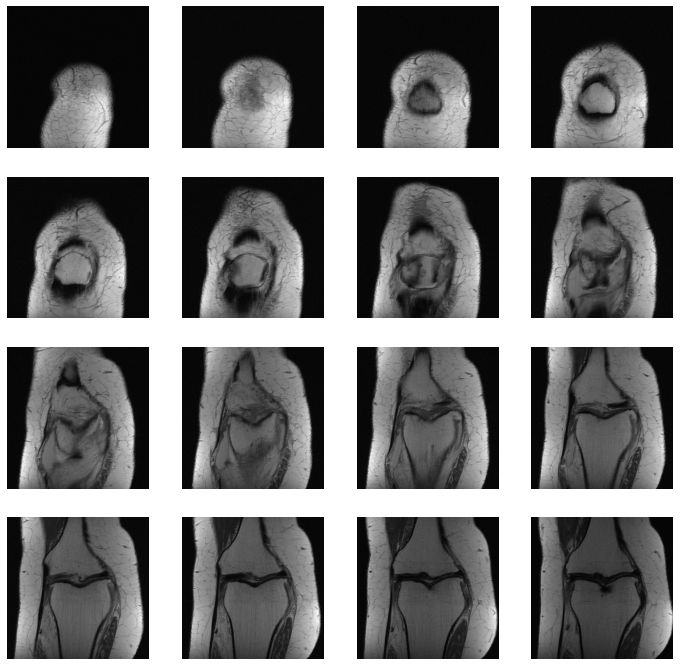

In [9]:
def show_examples(ds, fn, n=16):
  cols = 4
  rows = (n + cols - 1) // cols
  _, axs = plt.subplots(rows, cols, figsize=(12, 3 * rows), squeeze=False)
  if isinstance(ds, tf.data.Dataset):
    ds = ds.take(n)
  else:
    ds = itertools.islice(ds, n)
  for index, example in enumerate(ds):
    i, j = index // cols, index % cols
    axs[i, j].imshow(fn(example), cmap='gray')
    axs[i, j].axis('off')
  plt.show()

display_fn = lambda example: example['reconstruction_rss'].numpy()
show_examples(ds_train, display_fn)

In [12]:
def create_kspace_mask(kspace):
  """Subsamples a fastMRI example (single slice).

  Args:
    ds: A `tf.data.Dataset` object.
  """
  num_lines = tf.shape(kspace)[-1]
  density_1d = tfmri.sampling.density_grid(shape=[num_lines],
                                           inner_density=1.0,
                                           inner_cutoff=0.08,
                                           outer_cutoff=0.08,
                                           outer_density=0.25)
  mask_1d = tfmri.sampling.random_mask(
      shape=[num_lines], density=density_1d)
  mask_2d = tf.broadcast_to(mask_1d, tf.shape(kspace)[-2:])
  return mask_2d
  
def reconstruct_zerofilled(kspace, mask=None, sensitivities=None):
  image_shape = tf.shape(kspace)[-2:]
  image = tfmri.recon.adjoint(kspace, image_shape,
                              mask=mask, sensitivities=sensitivities)
  if sensitivities is None:
    image = tfmri.coils.combine_coils(image, coil_axis=-3)
  return image

def filter_kspace_lowpass(kspace):
  def box(freq):
    cutoff = fully_sampled_region * np.pi
    result = tf.where(tf.math.abs(freq) < cutoff, 1, 0)
    return result
  return tfmri.signal.filter_kspace(kspace, filter_fn=box, filter_rank=1)

def compute_sensitivities(kspace):
  filt_kspace = filter_kspace_lowpass(kspace)
  filt_image = reconstruct_zerofilled(filt_kspace)
  sensitivities = tfmri.coils.estimate_sensitivities(filt_image, coil_axis=-3)
  return sensitivities

def scale_kspace(kspace):
  filt_kspace = filter_kspace_lowpass(kspace)
  filt_image = reconstruct_zerofilled(filt_kspace)
  scale = tf.math.reduce_max(tf.math.abs(filt_image))
  return kspace / tf.cast(scale, kspace.dtype)

In [13]:
def preprocess_fastmri_example(example, training=True):
  # Drop the `reconstruction_rss` element. We will not be using that.
  if 'reconstruction_rss' in example:
    example.pop('reconstruction_rss')

  if training:
    # Crop to 320x320.
    image = tfmri.signal.ifft(example['kspace'], axes=[-2, -1], shift=True)
    image = tfmri.resize_with_crop_or_pad(image, [320, 320])
    example['kspace'] = tfmri.signal.fft(image, axes=[-2, -1], shift=True)

    # Create a subsampling mask.
    example['mask'] = create_kspace_mask(example['kspace'])
    full_kspace = example['kspace']
    example['kspace'] = tf.where(example['mask'], example['kspace'], 0)

    # Create output image from fully sampled k-space.
    full_kspace = scale_kspace(full_kspace)
    image = reconstruct_zerofilled(full_kspace)
    image = tf.expand_dims(image, -1)
    image = tf.math.abs(image)
    example = (example, image)
  return example

ds_train = ds_train.map(preprocess_fastmri_example)
ds_val = ds_val.map(preprocess_fastmri_example)
# ds_test = ds_test.map(functools.partial(preprocess_fastmri_example, training=False))

# display_fn = lambda example: np.abs(example['image'].numpy()[5, ...])
# show_examples(ds_train, display_fn, n=16)

In [14]:
batch_size = 1

ds_train = ds_train.shuffle(buffer_size=10)

def finalize_fastmri_dataset(ds):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

ds_train = finalize_fastmri_dataset(ds_train)
ds_val = finalize_fastmri_dataset(ds_val)
# ds_test = finalize_fastmri_dataset(ds_test, training=False) 

In [31]:
def create_keras_inputs(ds):
  return tf.nest.map_structure(
      lambda x, name: tf.keras.Input(shape=x.shape[1:], dtype=x.dtype, name=name),
      ds.element_spec[0], {k: k for k in ds.element_spec[0].keys()})

inputs = create_keras_inputs(ds_train)

print(inputs)

{'kspace': <KerasTensor: shape=(None, None, 320, 320) dtype=complex64 (created by layer 'kspace')>, 'mask': <KerasTensor: shape=(None, 320, 320) dtype=bool (created by layer 'mask')>}


In [32]:
def filter_kspace_lowpass(kspace):
  def box(freq):
    cutoff = fully_sampled_region * np.pi
    result = tf.where(tf.math.abs(freq) < cutoff, 1, 0)
    return result
  return tfmri.signal.filter_kspace(kspace, filter_fn=box, filter_rank=1)

# def scale_kspace(kspace, operator):
#   filt_kspace = filter_kspace_lowpass(kspace)
#   filt_image = operator.transform(filt_kspace, adjoint=True)
#   scale = tf.math.reduce_max(tf.math.abs(filt_image))
#   return kspace / tf.cast(scale, kspace.dtype)



class LinearOperatorLayer(tf.keras.layers.Layer):
  def __init__(self, operator, input_names, **kwargs):
    super().__init__(**kwargs)
    self.operator = operator
    self.input_names = input_names

  def parse_inputs(self, inputs):
    main = {k: inputs[k] for k in self.input_names}
    args = ()
    kwargs = {k: v for k, v in inputs.items() if k not in self.input_names}
    return main, args, kwargs

  def get_operator(self, inputs):
    main, args, kwargs = self.parse_inputs(inputs)
    return self.operator(*args, **kwargs)


class KSpaceScaling(LinearOperatorLayer):
  def __init__(self,
               operator=tfmri.linalg.LinearOperatorMRI,
               kspace_index='kspace',
               passthrough=False,
               **kwargs):
    super().__init__(operator=operator, input_names=(kspace_index,), **kwargs)
    self.operator = operator
    self.kspace_index = kspace_index
    self.passthrough = passthrough

  def call(self, inputs):
    main, args, kwargs = self.parse_inputs(inputs)
    kspace = self.scale_kspace(main[self.kspace_index], *args, **kwargs)
    if self.passthrough:
      return {self.kspace_index: kspace, **kwargs}
    return kspace

  def scale_kspace(self, kspace, *args, **kwargs):
    filt_kspace = filter_kspace_lowpass(kspace)
    filt_image = tfmri.recon.adjoint(filt_kspace, *args, **kwargs)
    scale = tf.math.reduce_max(tf.math.abs(filt_image))
    return kspace / tf.cast(scale, kspace.dtype)


class CoilSensitivities(LinearOperatorLayer):
  def __init__(self,
               operator=tfmri.linalg.LinearOperatorMRI,
               kspace_index='kspace',
               sensitivities_index='sensitivities',
               passthrough=False,
               **kwargs):
    super().__init__(operator=operator, input_names=(kspace_index,), **kwargs)
    self.kspace_index = kspace_index
    self.sensitivities_index = sensitivities_index
    self.passthrough = passthrough

  def call(self, inputs):
    main, args, kwargs = self.parse_inputs(inputs)
    # TODO: unused operator.
    sensitivities = self.compute_sensitivities(
        main[self.kspace_index], *args, **kwargs)
    if self.passthrough:
      return {self.kspace_index: main[self.kspace_index], **kwargs,
              self.sensitivities_index: sensitivities}
    return sensitivities

  def compute_sensitivities(self, kspace, *args, **kwargs):
    filt_kspace = filter_kspace_lowpass(kspace)
    filt_image = tfmri.recon.adjoint(filt_kspace, *args, **kwargs)
    sensitivities = tfmri.coils.estimate_sensitivities(filt_image, coil_axis=-3)
    return sensitivities


class ReconAdjoint(LinearOperatorLayer):
  def __init__(self,
               kspace_index='kspace',
               image_index='image',
               passthrough=False,
               **kwargs):
    super().__init__(operator=tfmri.linalg.LinearOperatorMRI,
                     input_names=(kspace_index,),
                     **kwargs)
    self.kspace_index = kspace_index
    self.image_index = image_index
    self.passthrough = passthrough

  def call(self, inputs):
    main, args, kwargs = self.parse_inputs(inputs)
    image = tfmri.recon.adjoint(main[self.kspace_index], *args, **kwargs)
    image = tf.expand_dims(image, -1)
    if self.passthrough:
      return {self.kspace_index: main[self.kspace_index], **kwargs,
              self.image_index: image}
    return image


In [33]:
# def BaselineUNet(inputs):
#   zfill = AdjointRecon(magnitude_only=True, name='zfill')(inputs)
#   image = tfmri.models.UNet2D(
#       filters=[32, 64, 128],
#       kernel_size=3,
#       out_channels=1,
#       name='image')(zfill)
#   outputs = {'zfill': zfill, 'image': image}
#   return tf.keras.Model(inputs=inputs, outputs=outputs)

# model = BaselineUNet(inputs)

# model.compile(optimizer='adam',
#               loss='mse',
#               metrics=[tfmri.metrics.PSNR(), tfmri.metrics.SSIM()])

# model.summary()

In [34]:
# model.fit(ds_train, epochs=10, validation_data=ds_val)

In [35]:
# preds = model.predict(ds_train.take(30))

In [36]:
# show_examples(preds['image'], lambda x: np.abs(x), n=16)

In [39]:
def VarNet(inputs, num_iterations=5):
  kspace = inputs['kspace']
  kwargs = {k: inputs[k] for k in inputs.keys() if k != 'kspace'}

  if 'image_shape' not in kwargs:
    kwargs['image_shape'] = tf.shape(kspace)[-2:]

  kspace = KSpaceScaling()({'kspace': kspace, **kwargs})
  kwargs['sensitivities'] = CoilSensitivities()({'kspace': kspace, **kwargs})

  zfill = ReconAdjoint()({'kspace': kspace, **kwargs})

  image = zfill
  for i in range(num_iterations):
    image = tfmri.models.UNet2D(
        filters=[32, 64, 128],
        kernel_size=3,
        activation=tfmri.activations.complex_relu,
        out_channels=1,
        dtype=tf.complex64,
        name=f'reg_{i}')(image)
    image = tfmri.layers.LeastSquaresGradientDescent(
        operator=tfmri.linalg.LinearOperatorMRI,
        dtype=tf.complex64,
        name=f'lsgd_{i}')(
            {'x': image, 'b': kspace, **kwargs})

  outputs = {'zfill': zfill, 'image': image}
  return tf.keras.Model(inputs=inputs, outputs=outputs)

model = VarNet(inputs)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tfmri.metrics.PSNR(), tfmri.metrics.SSIM()])

model.summary()

SyntaxError: invalid syntax (892461145.py, line 21)

In [38]:
model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)
(None, 320, 320) (None, None) (None, None, None)


2022-08-05 11:07:45.069637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


     76/Unknown - 89s 801ms/step - loss: 0.5787 - least_squares_gradient_descent_10_loss: 0.2163 - recon_adjoint_2_loss: 0.3624 - least_squares_gradient_descent_10_psnr: 10.0989 - least_squares_gradient_descent_10_ssim: 0.1636 - recon_adjoint_2_psnr: 6.0361 - recon_adjoint_2_ssim: 0.1031

KeyboardInterrupt: 